## Installations

In [27]:
# !pip install kaggle

# !pip install tqdm

# !pip install transformers

# !pip install datasets

# !pip install evaluate

# import sys

# !{sys.executable} -m pip install tqdm

# !{sys.executable} -m pip install accelerate

## Import Libraries

In [28]:
# hide HF warnings
import logging
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
logging.disable(logging.ERROR)

# Download Data
import os
import shutil
import kaggle

# Load Data
from datasets import load_dataset, DatasetDict
from pathlib import Path
import matplotlib.pyplot as plt

# Process Data
from transformers import ViTImageProcessor
import copy

# Build Model
import torch
from transformers import ViTForImageClassification
from transformers import TrainingArguments
from transformers import Trainer
import os
import numpy as np
import evaluate

# Visualize Attention
import cv2
import matplotlib.pyplot as plt

## Download Data

In [29]:
# # load dataset from kaggle
# kaggle.api.authenticate() # upload kaggle.json to home directory
# kaggle.api.dataset_download_files('fanconic/skin-cancer-malignant-vs-benign', path='data', unzip=True)

# # remove pre-defined test/train splits
# origin = 'data'
# for path in os.listdir(origin):
#     if path in ['test','train']:
#         base1 = os.path.join(origin, path)
#         for label in os.listdir(base1):
#             base2 = os.path.join(base1, label)
#             for file in os.listdir(base2):
#                 base3 = os.path.join(base2, file)
#                 shutil.copy(base3, 'data/'+label)

## Model Pipeline

In [30]:
def load_data(path):
    data = load_dataset("imagefolder", data_dir=path)

    seed = 42
    temp_a = data['train'].train_test_split(test_size=0.1, seed=seed)
    temp_b = temp_a['test'].train_test_split(test_size=0.5, seed=seed)

    return DatasetDict({
        'train': temp_a['train'],
        'test': temp_b['test'],
        'validation': temp_b['train']
    })

In [31]:
def process_data(data, model_id):
    processor = ViTImageProcessor.from_pretrained(model_id)
    
    def transform(batch):
        # convert PIL images into pixel values and process
        pixel_values = [x.convert("RGB") for x in batch['image']]
        inputs = processor(pixel_values, return_tensors='pt')
        
        # include labels
        inputs['label'] = batch['label']

        return inputs
        
    prepared_ds = copy.deepcopy(data).with_transform(transform)
        
    return prepared_ds, processor

In [32]:
def prepare_vit(data, model_id, unfreeze = None):
    # use labels to tune classifier head
    labels = data['train'].features['label'].names

    # retrieve model
    model = ViTForImageClassification.from_pretrained(
        model_id,
        num_labels=len(labels),
        id2label={str(i):c for i,c in enumerate(labels)},
        label2id={c:str(i) for i,c in enumerate(labels)}
    )

    # get total hidden layers
    num_layers = model.config.num_hidden_layers

    # unfreeze all layers if limit not specified
    unfreeze = num_layers if not unfreeze else unfreeze

    # unfreeze desired number of layers
    for (name, param) in model.named_parameters():
        param.requires_grad = True
        if '.layer.' in name:
            layer = int(name.split('.layer.')[1].split('.')[0])
            if layer < num_layers - unfreeze:
                param.requires_grad = False

    return model

In [33]:
def load_trainer(model, prepared_ds, processor, training_args):
    def collate_fn(batch):
        return {
            'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
            'labels': torch.tensor([x['label'] for x in batch])
        }

    def compute_metrics(p):
        metric = evaluate.load("accuracy")
        return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

    device = torch.device("xpu" if torch.xpu.is_available() else "cpu")
    trainer = Trainer(
        model=model,
        args=training_args,
        data_collator=collate_fn,
        compute_metrics=compute_metrics,
        train_dataset=prepared_ds["train"],
        eval_dataset=prepared_ds["validation"],
        tokenizer=processor,
        
    )
        
    return trainer

In [34]:
def model_generator(data, training_args):
    model_id = 'google/vit-base-patch16-224-in21k'
    unfreeze = None
    
    # process dataset
    prepared_ds, processor = process_data(
        data = data, 
        model_id = model_id
    )
      
    # initialize model
    model = prepare_vit(
        data = prepared_ds,
        model_id = model_id,  
        unfreeze = unfreeze
    )
    
    # initialize trainer
    trainer = load_trainer(
        model = model, 
        prepared_ds = prepared_ds, 
        processor = processor,
        training_args = training_args
    )
    
    # train model
    trainer.train()
    
    # test model
    metrics = trainer.evaluate(prepared_ds['test'])
    trainer.log_metrics("eval", metrics)
    
    return model

## Train/Test Model

In [35]:
# define arguments
training_args = TrainingArguments(
    output_dir=os.getcwd(),
    per_device_train_batch_size=32,
    evaluation_strategy='epoch',
    num_train_epochs=2,
    bf16=True,
    save_strategy = 'no',
    logging_strategy = 'epoch',
    learning_rate=1e-4,
    remove_unused_columns=False,
    report_to='none',
    seed = 0,
    data_seed = 0,
)

Resolving data files:   0%|          | 0/3297 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 2967
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 165
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 165
    })
})
malignant


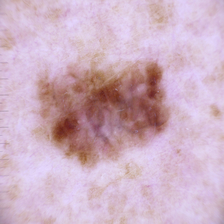

In [36]:
path = 'data'
data = load_data(path)

# print data summary
print(data)

# print reference image
ref_idx = 3
labels = data['train'].features['label']
print(labels.int2str(data['train'][ref_idx]['label']))
data['train'][ref_idx]['image']

In [37]:
model = model_generator(data, training_args)

***** eval metrics *****
  epoch                   =        2.0
  eval_accuracy           =      0.903
  eval_loss               =     0.2394
  eval_runtime            = 0:00:02.56
  eval_samples_per_second =     64.203
  eval_steps_per_second   =      8.171


In [38]:
# upload model
# model.push_to_hub("vit-skin-cancer")

## Attention Maps

In [39]:
def get_attention_map(image, get_mask=True, layer=-1):
    model_id = 'google/vit-base-patch16-224-in21k'
    processor = ViTImageProcessor.from_pretrained(model_id)
    inputs = processor(image, return_tensors='pt')['pixel_values']
    outputs = model(inputs, output_attentions=True)
    att_mat = outputs.attentions

    att_mat = torch.stack(att_mat).squeeze(1)

    # average the attention weights across all heads
    att_mat = torch.mean(att_mat, dim=1)

    # to account for residual connections, we add an identity matrix to the
    # attention matrix and re-normalize the weights.
    residual_att = torch.eye(att_mat.size(1))
    aug_att_mat = att_mat + residual_att
    aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

    # recursively multiply the weight matrices
    joint_attentions = torch.zeros(aug_att_mat.size())
    joint_attentions[0] = aug_att_mat[0]

    for n in range(1, aug_att_mat.size(0)):
        joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])
    
    # get attention from specified layer
    v = joint_attentions[layer]
    
    # copy attentions to host memory for numpy conversion
    v = v.to(torch.device("cpu"))
    
    grid_size = int(np.sqrt(aug_att_mat.size(-1)))
    mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
    if get_mask:
        result = cv2.resize(mask / mask.max(), image.size)
    else:        
        mask = cv2.resize(mask / mask.max(), image.size)[..., np.newaxis]
        mask[mask < 0.7] = 0.2
        result = (mask * image).astype("uint8")
    
    return result

In [40]:
def get_prediction(model, image):
    model_id = 'google/vit-base-patch16-224-in21k'
    processor = ViTImageProcessor.from_pretrained(model_id)
    inputs = processor(image, return_tensors='pt')['pixel_values']
    logits = model(inputs).logits
    logits = logits.to(torch.device("cpu"))
    p = torch.nn.functional.softmax(logits, dim=1)
    p = np.max(p.detach().numpy(), axis=-1).item()
    pred_class_idx = np.argmax(logits.detach().numpy(), axis=-1)
    return model.config.id2label[str(pred_class_idx.item())], p

In [41]:
def get_label(data, idx):
    labels = data.features['label']
    return labels.int2str(data[idx]['label'])

In [42]:
def plot_attention_map(model, dataset, idx):
    image = dataset[idx]['image'].convert("RGB")
    
    pred = get_prediction(model,image)
    label = get_label(dataset,idx)
    
    att_map = get_attention_map(image)
    
    fig, axs = plt.subplots(ncols=2, figsize=(16, 16))
    axs[0].set_title(f'Original ({label})')
    axs[1].set_title(f'Attention Map ({pred[0]}, {round(pred[1]*100.0,0)}%)')
    _ = axs[0].imshow(image)
    _ = axs[1].imshow(att_map)
    # txt=f'Label: {label} \n Prediction: {pred}'
    # plt.figtext(0.5, 0.67, txt, wrap=True, horizontalalignment='center', fontsize=12)
    axs = [ax.axis('off') for ax in axs]
    plt.show()

In [43]:
def visualize(model, data, split, idx):
    with torch.no_grad() and model.device: 
        plot_attention_map(model, data[split], idx)

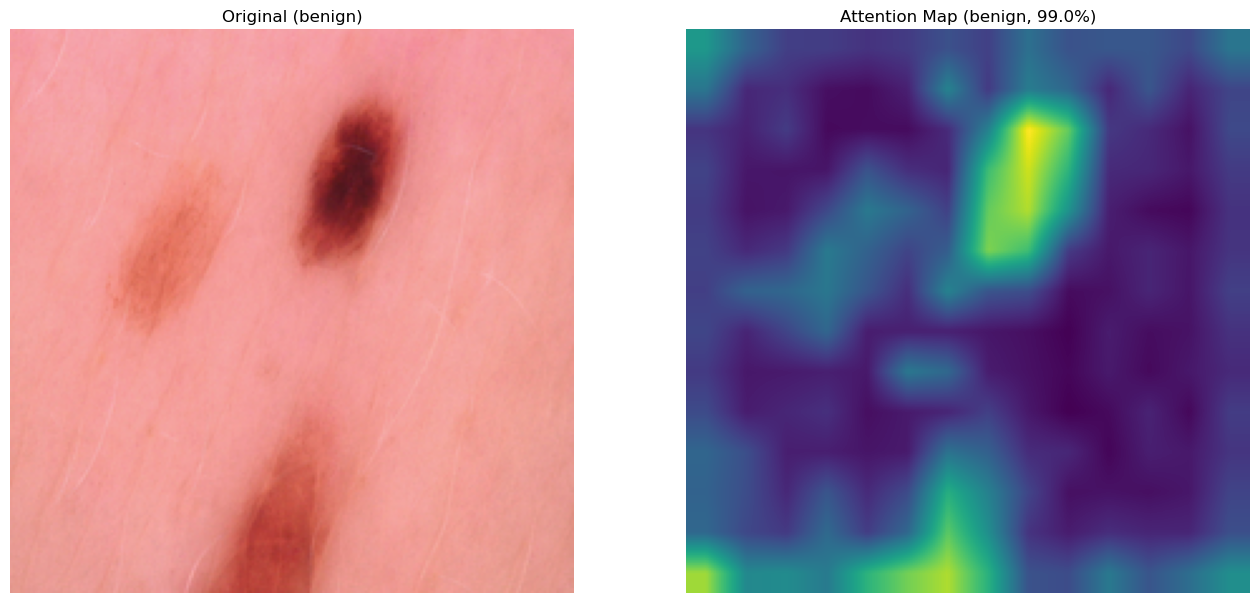

In [44]:
visualize(model, data, 'train', 0)

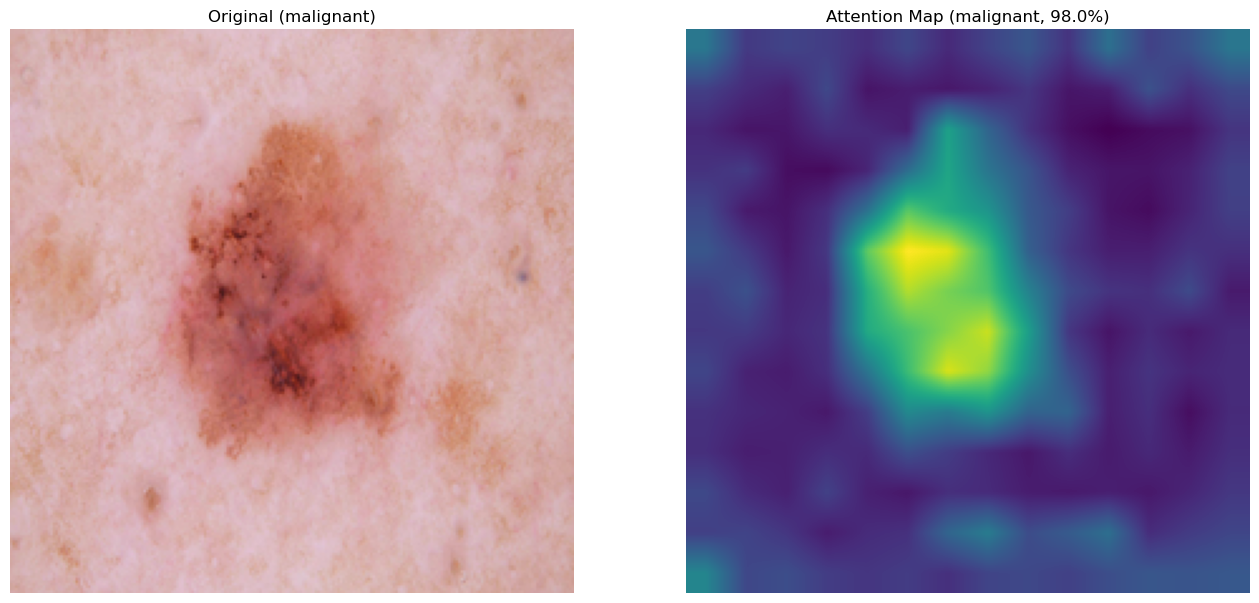

In [45]:
visualize(model, data, 'test', 1)

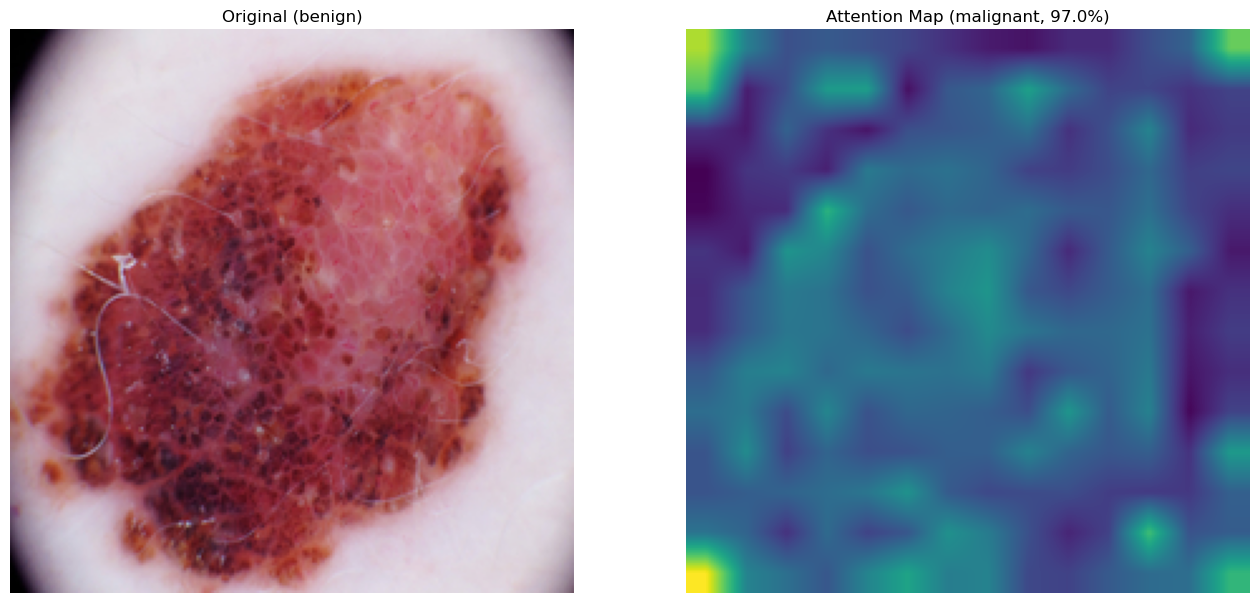

In [46]:
visualize(model, data, 'test', 0)

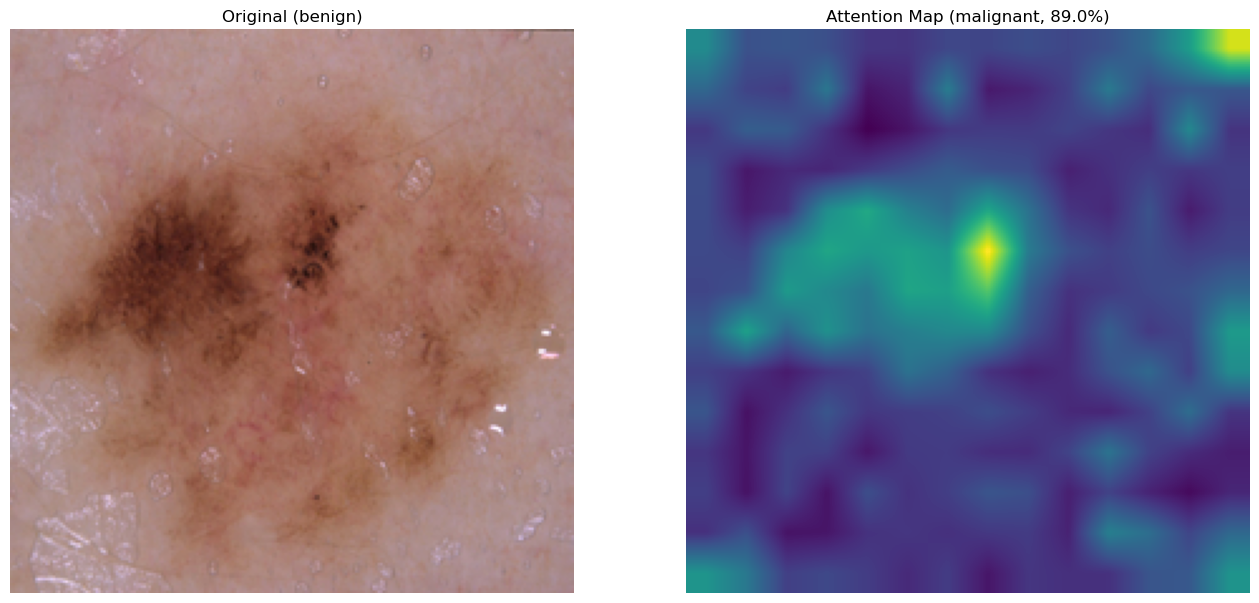

In [47]:
visualize(model, data, 'test', 17)

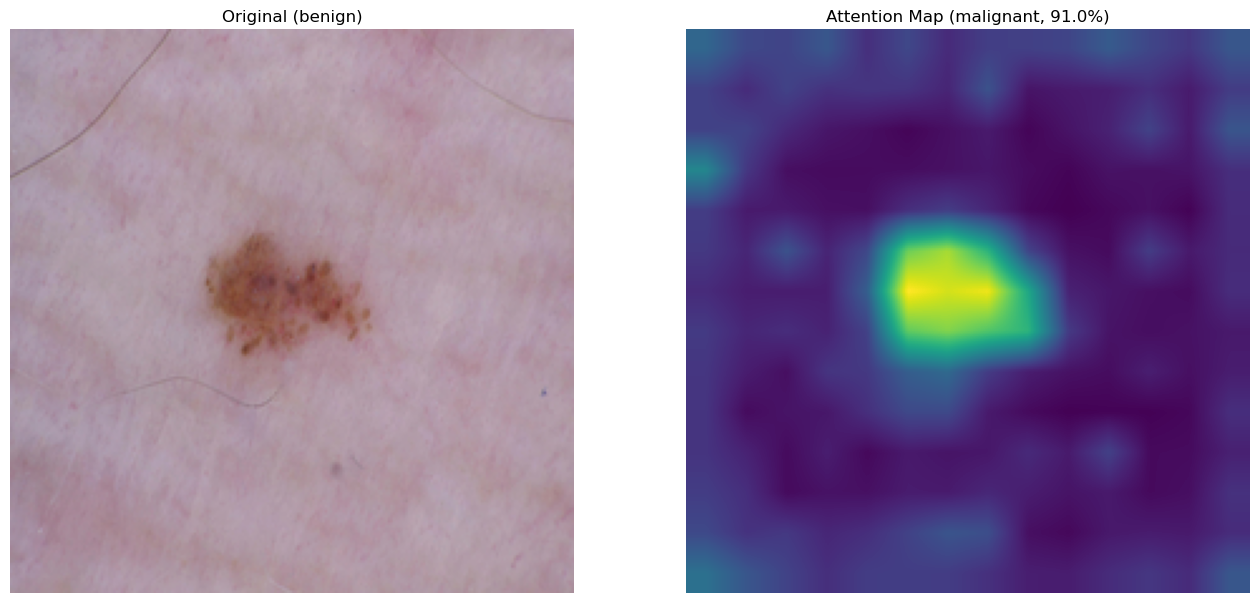

In [48]:
visualize(model, data, 'test', 32)

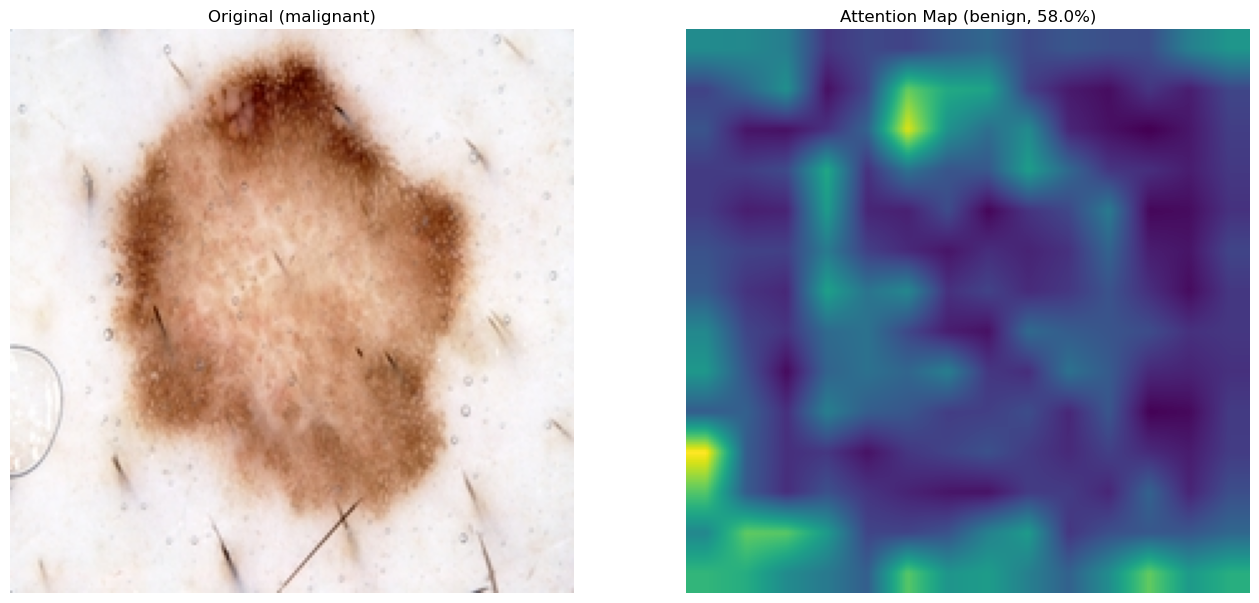

In [49]:
visualize(model, data, 'test', 34)

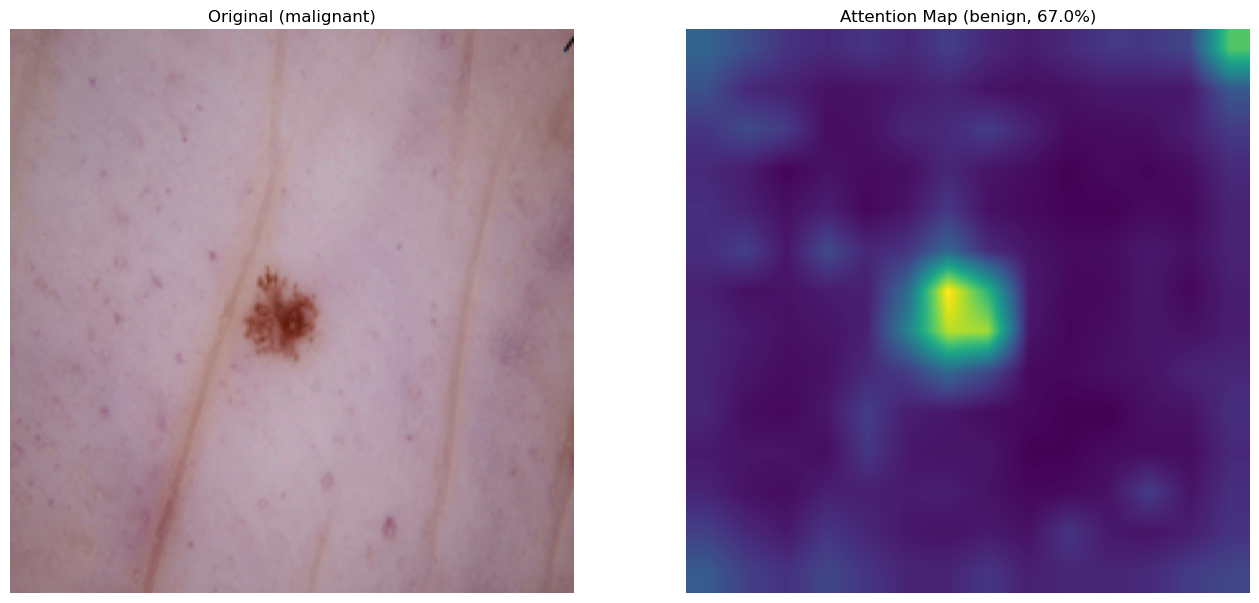

In [50]:
visualize(model, data, 'test', 112)

## Incorrect Predictions

In [51]:
# INCORRECT PREDICTION FINDER
from tqdm import tqdm
missed = {'train':[],'test':[],'validation':[]}
model_id = 'google/vit-base-patch16-224-in21k'
processor = ViTImageProcessor.from_pretrained(model_id)
with torch.no_grad() and model.device:
    for split in ['train','test','validation']:
        count = 0
        print(f'Checking {split} dataset...')
        for idx in tqdm(range(data[split].shape[0])):
            label = data[split][idx]['label']
            image = data[split][idx]['image'].convert("RGB")
            inputs = processor(image, return_tensors='pt')['pixel_values']
            logits = model(inputs).logits
            logits = logits.to(torch.device("cpu"))
            pred = np.argmax(logits.detach().numpy(), axis=-1)
            if label != pred[0] and idx not in missed[split]:
                count += 1
                missed[split].append(idx)
        print(f'Found {count} incorrect predictions!')
        print()

Checking train dataset...


100%|██████████| 2967/2967 [01:16<00:00, 38.64it/s]


Found 62 incorrect predictions!

Checking test dataset...


100%|██████████| 165/165 [00:04<00:00, 37.07it/s]


Found 16 incorrect predictions!

Checking validation dataset...


100%|██████████| 165/165 [00:04<00:00, 37.53it/s]

Found 18 incorrect predictions!



In [52]:
missed

{'train': [66,
  223,
  314,
  339,
  347,
  348,
  359,
  546,
  548,
  671,
  673,
  704,
  713,
  721,
  746,
  786,
  799,
  827,
  865,
  955,
  980,
  1052,
  1112,
  1164,
  1217,
  1222,
  1231,
  1234,
  1269,
  1326,
  1358,
  1362,
  1416,
  1531,
  1593,
  1648,
  1707,
  1709,
  1841,
  1851,
  1879,
  1893,
  1900,
  1975,
  2032,
  2053,
  2087,
  2123,
  2168,
  2322,
  2392,
  2419,
  2450,
  2588,
  2666,
  2671,
  2760,
  2780,
  2799,
  2867,
  2900,
  2951],
 'test': [0,
  13,
  17,
  32,
  34,
  49,
  56,
  78,
  101,
  103,
  112,
  130,
  135,
  144,
  147,
  161],
 'validation': [7,
  16,
  40,
  42,
  68,
  75,
  76,
  89,
  104,
  107,
  112,
  122,
  130,
  136,
  140,
  149,
  160,
  163]}